In [4]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


x_train_text = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/t2e/text_train.csv')
x_test_text = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/t2e/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/s2e/audio_train.csv')
x_test_audio = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/s2e/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(7837, 3) (7837,) (7837, 10) (7837,)


In [5]:
x_train_audio

,wav_file,label,sig_mean,sig_std,rms_mean,rms_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses04M_script02_2_M038,4,0.004841,0.010331,0.005035,0.020822,0.298408,0.169859,0.000221,0.000088
1,Ses03M_impro08a_F023,2,0.014103,0.020905,0.014573,0.034341,0.489741,0.171830,0.000701,0.000545
2,Ses02F_impro03_M007,4,0.046714,0.057852,0.049352,0.074707,0.296524,0.171239,0.004401,0.002296
3,Ses01M_impro05_F000,5,0.071723,0.118935,0.074084,0.201607,0.764284,0.171679,0.020934,0.014458
4,Ses05F_script01_2_M004,2,0.008553,0.018058,0.008947,0.034943,0.758333,0.171445,0.000601,0.000538
...,...,...,...,...,...,...,...,...,...,...
7832,Ses04F_impro08_M012,5,0.014352,0.021117,0.014942,0.034313,0.612563,0.171005,0.000712,0.000576
7833,Ses03M_impro04_F023,5,0.013690,0.017359,0.014105,0.024708,0.372635,0.171860,0.000457,0.000461
7834,Ses04F_impro04_M001,5,0.007561,0.010325,0.007827,0.016365,0.505575,0.170818,0.000189,0.000214
7835,Ses01F_script03_2_M015,2,0.008348,0.014455,0.008722,0.026289,0.005061,0.170984,0.000381,0.000324


In [6]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [7]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## Get Text Features

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features_text = tfidf.fit_transform(x_train_text.append(x_test_text).transcription).toarray()

x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(9797, 2464) (7837, 2464) (1960, 2464)


C:\Users\HP\AppData\Local\Temp\ipykernel_4912\2988164884.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_text = tfidf.fit_transform(x_train_text.append(x_test_text).transcription).toarray()


## Combine Text + Audio Features

In [9]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)


with open('C:/Users/HP/Multimodal/combined/combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)

(7837, 2472) (1960, 2472)


Test Set Accuracy =  0.660
Test Set F-score =  0.660
Test Set Precision =  0.702
Test Set Recall =  0.652
Confusion matrix, without normalization
[[ 85  17 104   0   4  17]
 [ 22 133 127   1   3  43]
 [ 33  22 482   1   4  49]
 [  0   0   0 267   0   0]
 [  0   0   0   0 223   0]
 [ 13  18 186   0   3 103]]


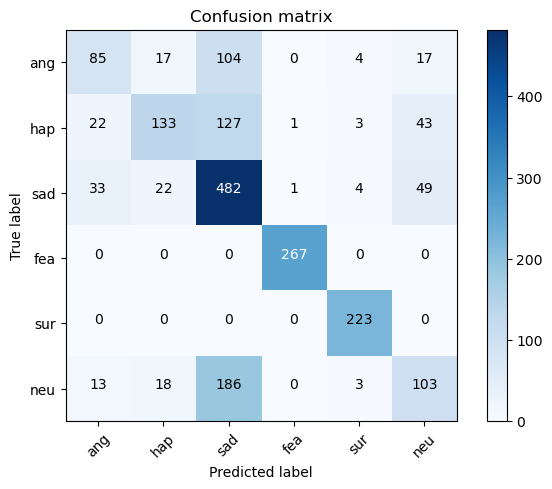

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Test Set Accuracy =  0.618
Test Set F-score =  0.617
Test Set Precision =  0.677
Test Set Recall =  0.604
Confusion matrix, without normalization
[[ 87  10 115   0   3  12]
 [ 23 115 156   1   4  30]
 [ 33  24 478   3   4  49]
 [  0   0   6 261   0   0]
 [  0   5  28   0 190   0]
 [ 16  17 199   3   7  81]]


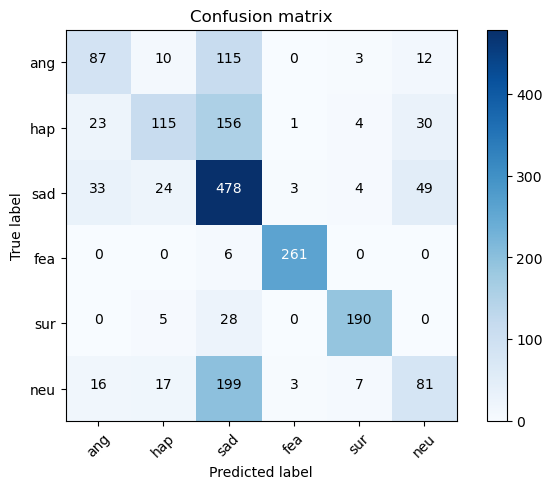

In [13]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.638
Test Set F-score =  0.648
Test Set Precision =  0.651
Test Set Recall =  0.651
Confusion matrix, without normalization
[[121  10  56   5  10  25]
 [ 10 186  59  15  12  47]
 [ 46  36 378  19  24  88]
 [  0   0  16 251   0   0]
 [  3   1  26   9 184   0]
 [ 14  35 120   8  16 130]]


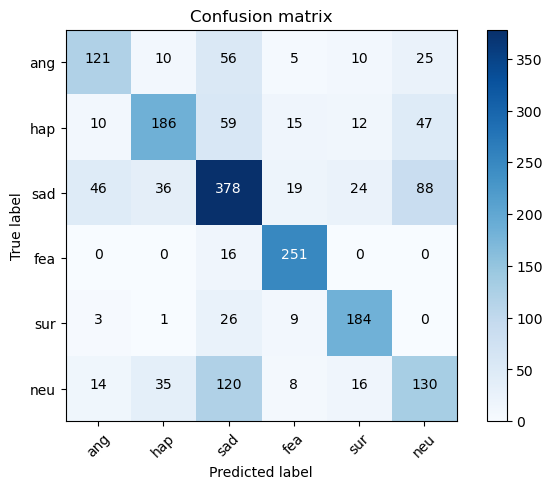

In [14]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.598
Test Set F-score =  0.600
Test Set Precision =  0.700
Test Set Recall =  0.562
Confusion matrix, without normalization
[[ 80  10 113   2  10  12]
 [  4 158 121   6   8  32]
 [ 18  24 492   1   7  49]
 [  0   0  76 191   0   0]
 [  0   1  68   0 154   0]
 [  8  21 183   8   5  98]]


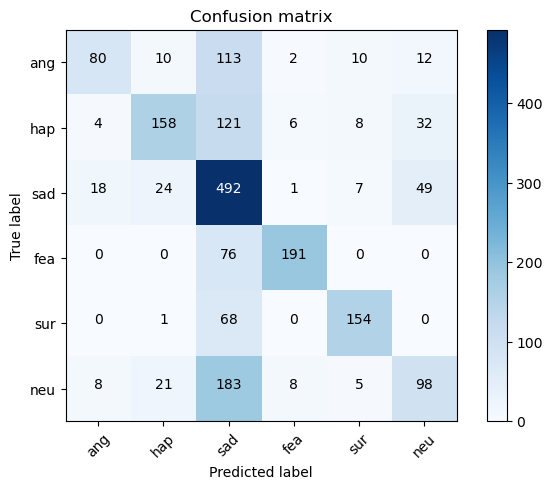

In [15]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.667
Test Set F-score =  0.686
Test Set Precision =  0.685
Test Set Recall =  0.691
Confusion matrix, without normalization
[[119   7  66   1   6  28]
 [ 13 189  59   7   5  56]
 [ 53  48 367   9  16  98]
 [  0   0   0 267   0   0]
 [  0   0   7   4 212   0]
 [ 19  32 109   4   6 153]]


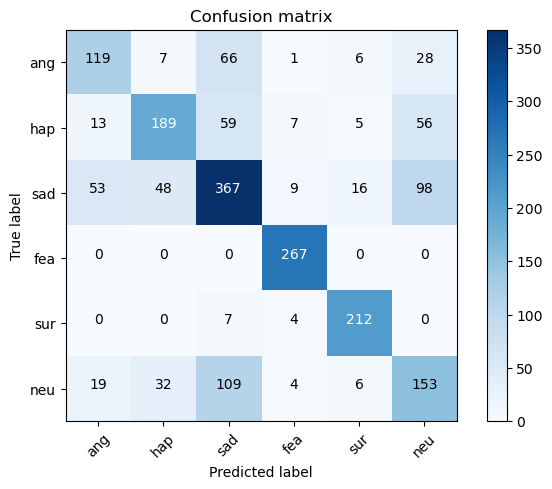

In [16]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.633
Test Set F-score =  0.642
Test Set Precision =  0.681
Test Set Recall =  0.623
Confusion matrix, without normalization
[[112  11  76   0   9  19]
 [  7 178  86   7  12  39]
 [ 34  29 443   3  19  63]
 [  7   0  54 206   0   0]
 [  3   2  39   1 178   0]
 [ 11  27 140   6  15 124]]


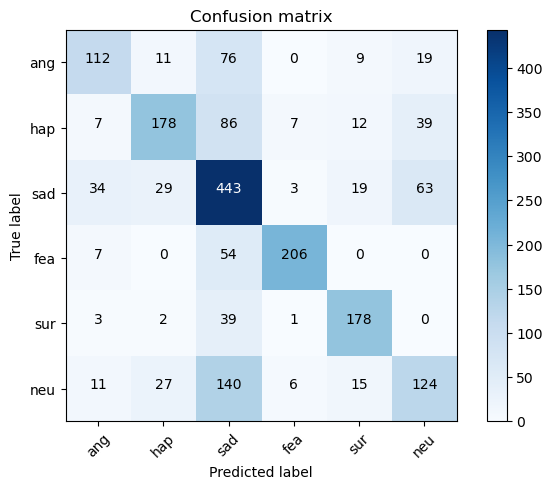

In [17]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

[0.00129829 0.00217873 0.00426571 ... 0.         0.         0.        ]


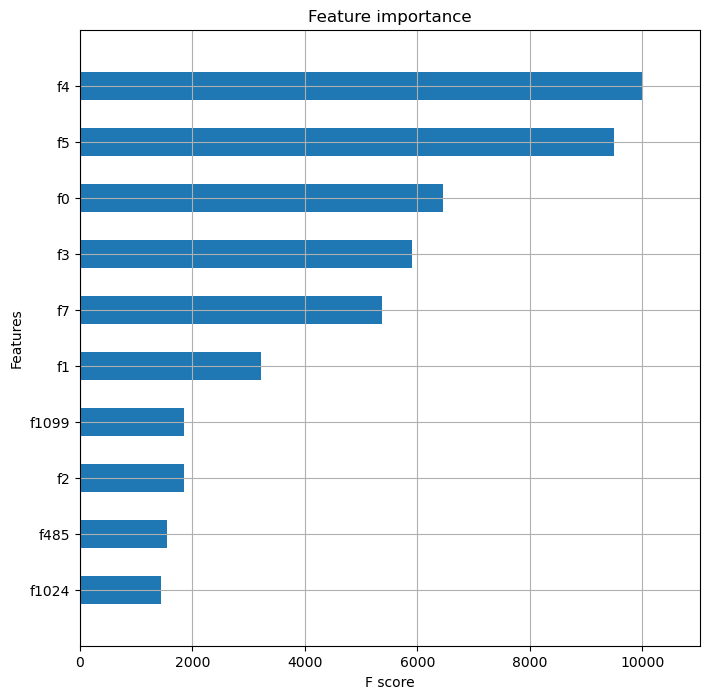

In [18]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
contribution_scores = xgb_classifier.feature_importances_
print(contribution_scores)

Test Set Accuracy =  0.704
Test Set F-score =  0.717
Test Set Precision =  0.740
Test Set Recall =  0.708
Confusion matrix, without normalization
[[115   4  86   0   5  17]
 [ 10 189  78   4   4  44]
 [ 35  27 452   2   5  70]
 [  0   0   0 267   0   0]
 [  0   0   9   0 214   0]
 [ 14  24 136   3   4 142]]


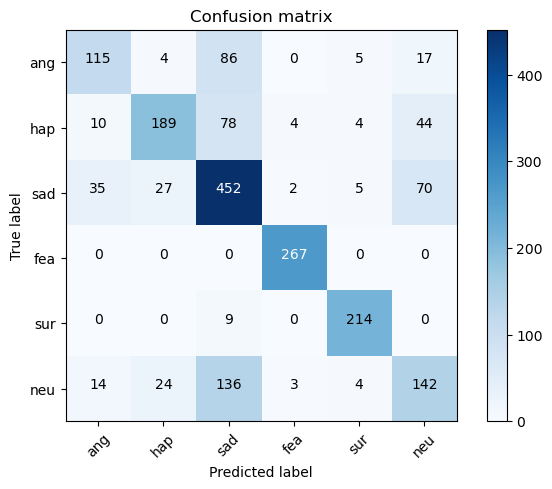

In [7]:
# Load predicted probabilities
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

#with open('pred_probas/combined_lstm_classifier.pkl', 'rb') as f:
    #lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

In [8]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import f1_score, accuracy_score

In [21]:
# Hard Voting Classifier
hard_voting = VotingClassifier(estimators=[
          ('mlp', mlp_classifier),
          ('rf', rf_classifier),
          ('svc',svc_classifier)],
           voting='hard')

In [23]:
hard_voting.fit(combined_x_train, y_train)

# Predict
pred_probs = hard_voting.predict(combined_x_test)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/hard_voting_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/HV.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

In [24]:
accuracy_score(y_test, pred_probs)

0.6938775510204082

In [10]:
# Load models
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/MLP.pkl', 'rb') as f:
    mlp_classifier = pickle.load(f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/RF.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/LR.pkl', 'rb') as f:
    lr_classifier = pickle.load(f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/XGB.pkl', 'rb') as f:
    xgb_classifier = pickle.load(f)

In [11]:
# Soft Voting Classifier
s_voting = VotingClassifier(estimators=[
          ('mlp', mlp_classifier),
          ('rf', rf_classifier),
    ('lr',lr_classifier),
    ('xgb',xgb_classifier)],
           voting='soft')

In [ ]:
s_voting.fit(combined_x_train, y_train)

# Predict
pred_probs = s_voting.predict(combined_x_test)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/s_voting_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/SV.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
accuracy_score(y_test, pred_probs)

In [ ]:
display_results(y_test, pred_probs)

In [10]:
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/combined/SV.pkl', 'rb') as f:
    sv = pickle.load(f)

In [14]:
pred_probs = sv.predict(combined_x_test)


In [15]:
conf_matrix = confusion_matrix(y_test, pred_probs)

print(conf_matrix)


[[112  11  76   0   9  19]
 [  7 178  86   7  12  39]
 [ 34  29 443   3  19  63]
 [  7   0  54 206   0   0]
 [  3   2  39   1 178   0]
 [ 11  27 140   6  15 124]]


Confusion matrix, without normalization
[[112  11  76   0   9  19]
 [  7 178  86   7  12  39]
 [ 34  29 443   3  19  63]
 [  7   0  54 206   0   0]
 [  3   2  39   1 178   0]
 [ 11  27 140   6  15 124]]


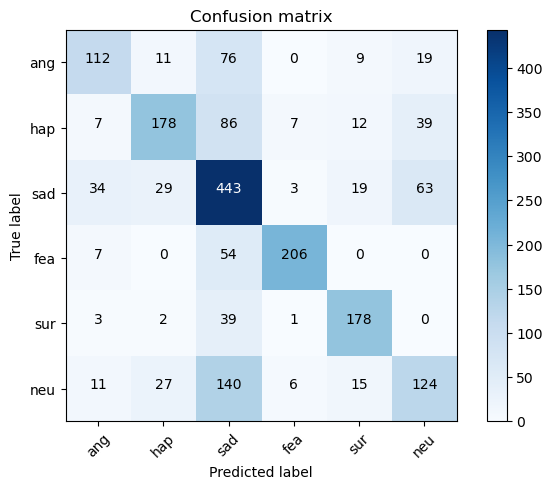

In [17]:
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm=True
plot_confusion_matrix(confusion_matrix(y_test, pred_probs), classes=emo_keys)